In [1]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import seaborn as sns
import random
import IPython.display
import librosa
from sklearn.model_selection import train_test_split
import torchaudio.transforms as transforms
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import tensorflow.keras.layers as L

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 6} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [3]:
audios = []
labels = []
audio_files = os.listdir('Crema')
for file in audio_files:
    labels.append(file.split('_')[2])
    # fs,data = wavfile.read(os.path.join('Crema',file))
    data, fs = librosa.load(os.path.join('Crema',file),sr=None)
    audios.append([data,fs])
    

In [4]:
print(len(labels))
print(len(audios))

7442
7442


In [5]:
set(labels)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [6]:
fs_list = [x for _,x in audios]
set(fs_list) # all files have a sample rate of 16kHz

{16000}

,data,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ANG
1,"[[0.00091552734, 0.0013122559, 0.0015869141, 0...",DIS
2,"[[0.008026123, 0.008453369, 0.008361816, 0.007...",FEA
3,"[[-0.004333496, -0.0032653809, -0.0030212402, ...",HAP
4,"[[0.0024108887, 0.001373291, 0.0013122559, 0.0...",NEU
...,...,...
7437,"[[0.00091552734, 0.0014038086, 0.001373291, 0....",DIS
7438,"[[-0.006958008, -0.0067749023, -0.0072021484, ...",FEA
7439,"[[-0.0022583008, -0.0018615723, -0.002319336, ...",HAP
7440,"[[-0.0016174316, -0.0010681152, -0.00076293945...",NEU


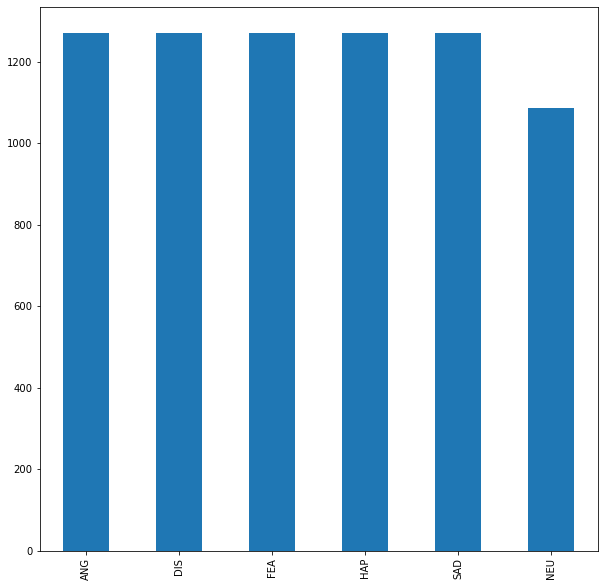

In [7]:
df = pd.concat([pd.Series(audios,name='data'),pd.Series(labels,name='label')],axis=1)
df['label'].value_counts().plot(kind='bar',figsize=(10,10))
df

In [8]:
audio = df['data'][0][0]
a = np.array(audio,dtype='float')
a.size

# zcr = np.nonzero(np.diff(audio > 0))[0]
# zero_crosses.size/audio.size
zcr=librosa.feature.zero_crossing_rate(a,frame_length=2048,hop_length=128)
# for i in np.squeeze(zcr):
#     print(i)
np.squeeze(zcr).size


285

In [9]:
emotions = {'ANG':'Angry','SAD':'Sad','NEU':'Neutral','HAP':'Happy','FEA':'Fear','DIS':'Disgust'}
colors = {'ANG':'red','SAD':'navy','NEU':'black','HAP':'yellow','FEA':'purple','DIS':'green'}

def load_audio(df,emotion):

    audios = list(df[df['label'] == emotion]['data'])
    idx = random.randint(0,len(audios)-1) # choosing a random file of that emotion
    audio = audios[idx][0]
    fs = audios[idx][1]
    duration = len(audio)/fs

    time = np.arange(0,duration,1/fs) # time vector

    plt.figure(figsize=(16,8))
    plt.plot(time,audio,color=colors[emotion])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(emotions[emotion] + ' Waveform')
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    plt.show()
    return audio, fs

In [10]:
def create_spectrogram(data, fs, emotion):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=fs, x_axis='time', y_axis='hz')
    plt.colorbar()

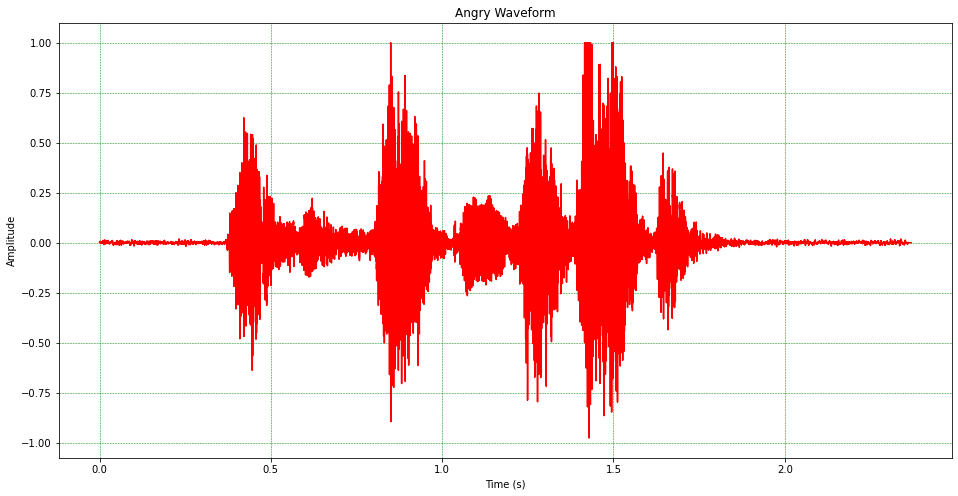

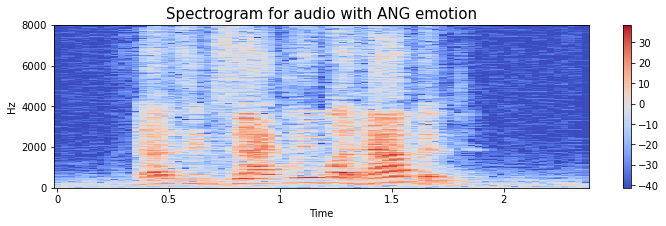

In [11]:
# ANGRY
audio,fs = load_audio(df,'ANG')
IPython.display.Audio(audio,rate=fs)
create_spectrogram(audio,fs,'ANG')


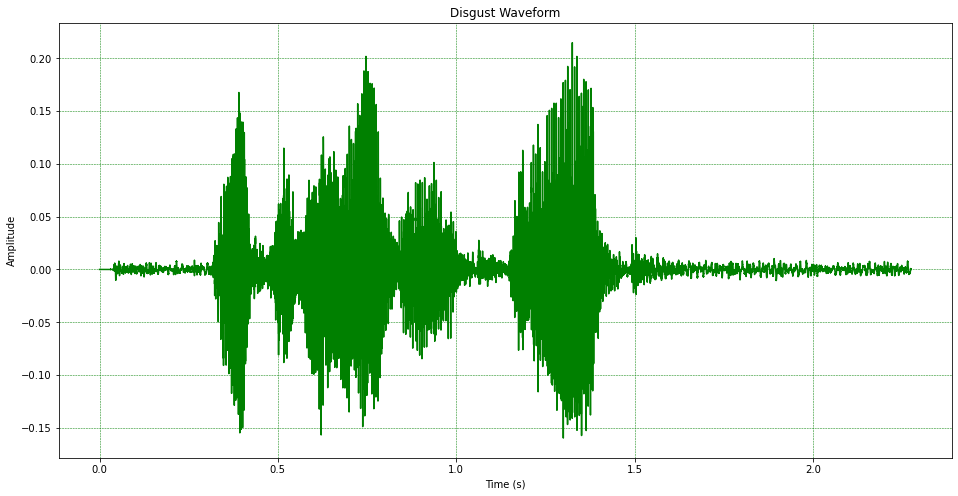

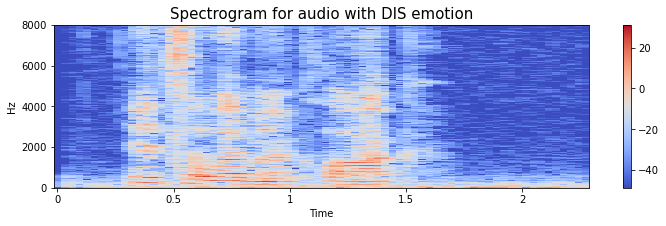

In [12]:
# DISGUSTED 
audio,fs = load_audio(df,'DIS')
IPython.display.Audio(audio,rate=fs)
create_spectrogram(audio,fs,'DIS')


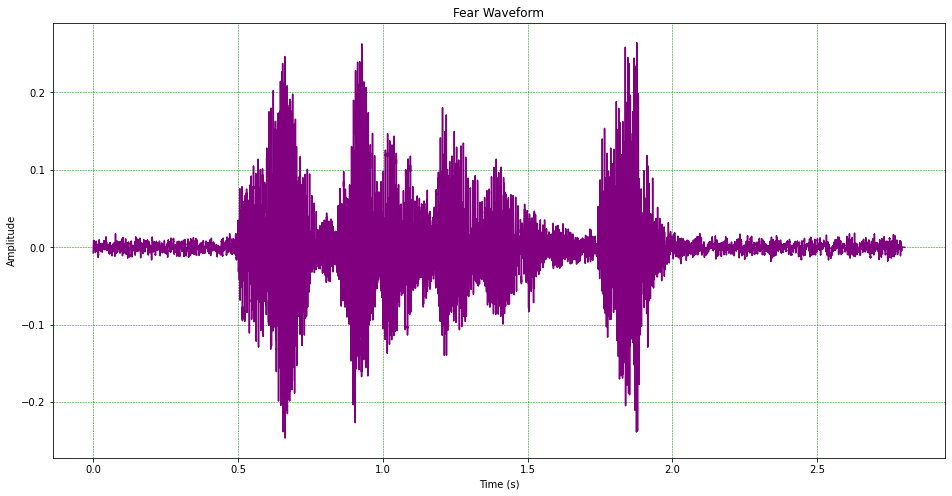

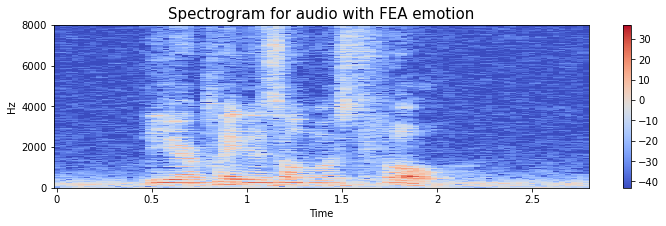

In [13]:
# FEAR
audio,fs = load_audio(df,'FEA')
IPython.display.Audio(audio,rate=fs)
create_spectrogram(audio,fs,'FEA')

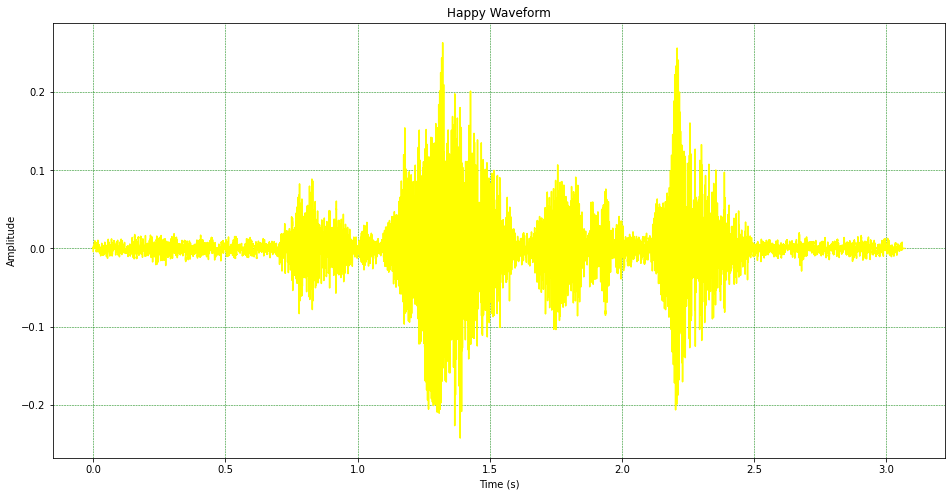

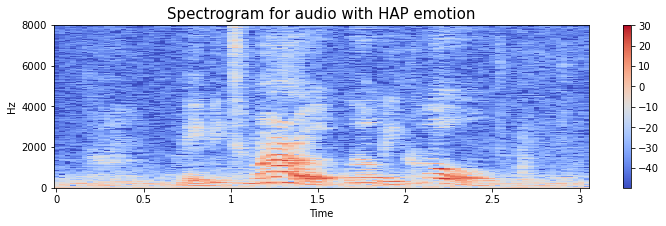

In [14]:
# HAPPY
audio,fs = load_audio(df,'HAP')
IPython.display.Audio(audio,rate=fs)
create_spectrogram(audio,fs,'HAP')


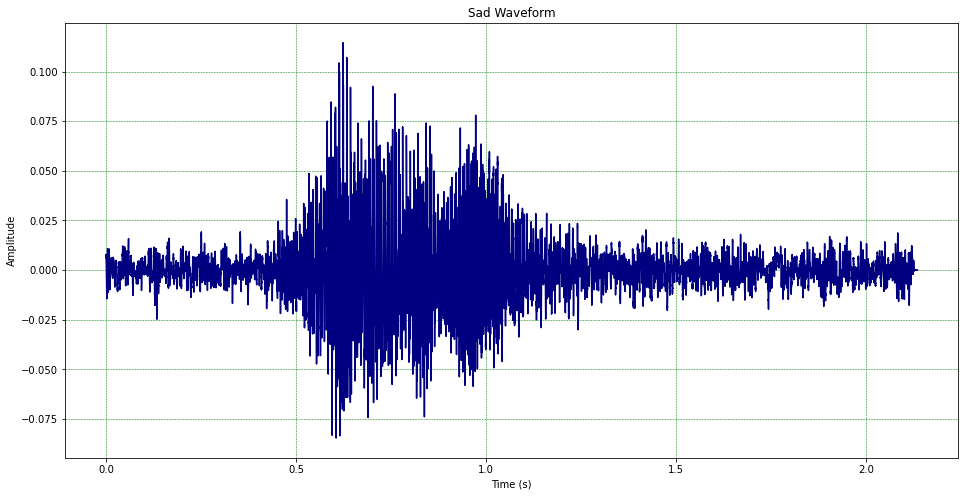

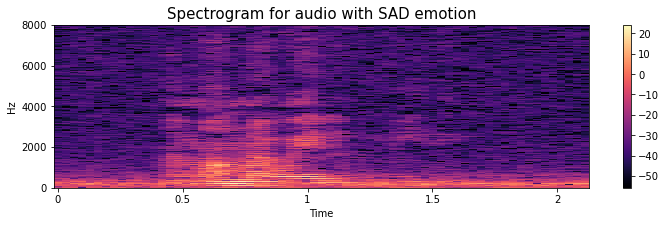

In [15]:
# SAD
audio,fs = load_audio(df,'SAD')
IPython.display.Audio(audio,rate=fs)
create_spectrogram(audio,fs,'SAD')

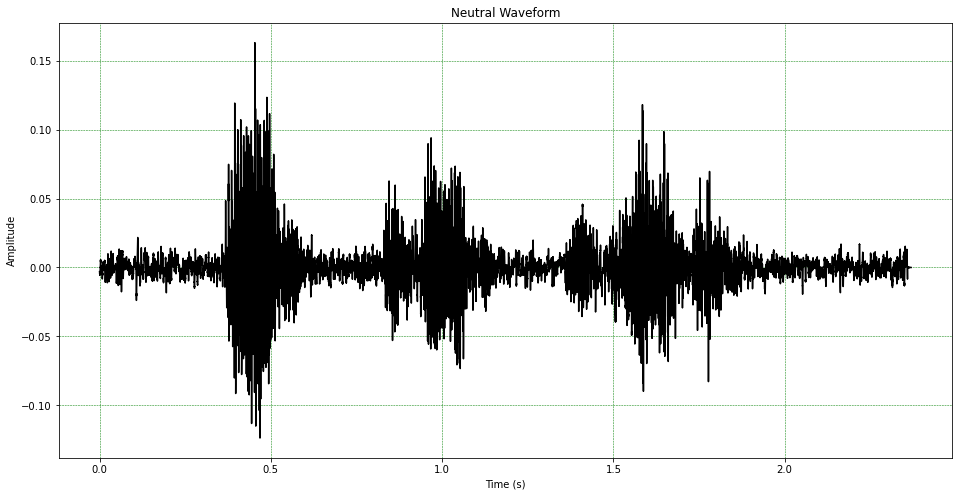

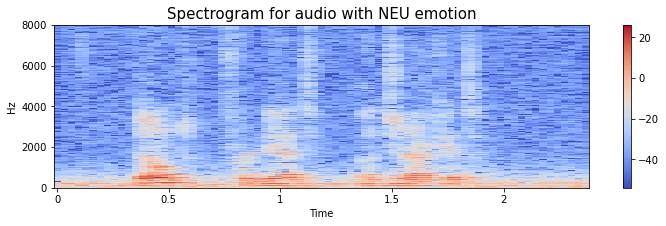

In [16]:
# NEUTRAL
audio,fs = load_audio(df,'NEU')
IPython.display.Audio(audio,rate=fs)
create_spectrogram(audio,fs,'NEU')

In [17]:
def pad(list,mel_spectrogram=False):
    padded_list = []
    if not mel_spectrogram:
        max_len =  max([i.size for i in list])
        for l in list:
            if not l.size == max_len:
                padded_list.append(np.pad(l, (0, max_len-l.size), 'constant'))
            else:
                padded_list.append(l)
    else:
        max_len =  max([i.shape[0] for i in list])
        for l in list:
            if not l.shape[0] == max_len:
                padded_list.append(np.pad(l, [(0, max_len-l.shape[0]), (0, 0)], mode='constant'))
            else:
                padded_list.append(l)
    return padded_list


In [18]:
df.to_numpy().shape

(7442, 2)

In [19]:
df['data'][0][0]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.1035156e-05,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [20]:
mels = []
for i in range(df.to_numpy().shape[0]):
    mel = librosa.feature.melspectrogram(y=df['data'][i][0], sr=df['data'][i][1],n_fft=1024,n_mels=157).T
    mels.append(mel)




In [21]:
padded_mels=pad(mels,mel_spectrogram=True)

In [22]:
padded_mels[4].shape

(157, 157)

In [32]:
def create_feature_space(df,mel_spectrogram=False):
    labels = []
    if not mel_spectrogram: # time/freq domain feature space
        feature_space = []
        zcrs=[]
        energies=[]
        mfccs=[]
        lfccs = []
        transform = transforms.LFCC(
        speckwargs={"n_fft": 400, "hop_length": 512, "center": False})
        for i,data in enumerate(df.to_numpy()):
            audio = np.array(data[0][0],dtype='float')
            fs = data[0][1]
            # zero_crosses = np.nonzero(np.diff(audio > 0))[0]
            # zcr = zero_crosses.size/len(audio) # zero crossing rate

            # zero crossing rate
            zcr=np.squeeze(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=128))
            # print(zcr.shape)
            zcrs.append(zcr)

            # normalized energy
            # energy=np.squeeze(librosa.feature.rms(audio,frame_length=2048,hop_length=128))
            energy = np.array([sum(abs(audio[i:i+2048]**2))/2048 for i in range(0, len(audio), 128)])
            # print(energy.shape)
            energies.append(energy)

            # mel frequency cepstral coefficient (MFCC)
            mfcc=np.ravel(librosa.feature.mfcc(y=audio,sr=fs).T)
            # print(mfcc.shape)
            mfccs.append(mfcc)
            
            # lfcc = transform(tf.convert_to_tensor(audio)[0])
            # lfccs.append(lfcc.numpy())
            
            # feature_space.append(np.concatenate((zcr,energy,mfcc), axis=None))
            labels.append(data[1])

            if i%1000==0:
                print(f'audio #{i} checkpoint')

        # max_len = max([len(i) for i in zcrs]) # find the longest list of scr to pad the others until they have equal length
        zcrs = pad(zcrs)
        energies = pad(energies)
        mfccs = pad(mfccs)
        # lfccs = pad(lfccs)

        for i in range(df.to_numpy().shape[0]):
            # feature_space.append(np.concatenate((zcrs[i],energies[i],mfccs[i],lfccs[i]), axis=None))
            feature_space.append(np.concatenate((zcrs[i],energies[i],mfccs[i]), axis=None))

        
        return feature_space,labels
    else:
        mels=[]
        for i,data in enumerate(df.to_numpy()):
            audio = data[0][0]
            fs = data[0][1]
            mel = librosa.feature.melspectrogram(y=audio, sr=fs, n_fft=1024,n_mels=157).T
            mels.append(mel)
            labels.append(data[1])
            if i%1000==0:
                print(f'audio #{i} checkpoint')
        mels = pad(mels,mel_spectrogram=True)
        return mels,labels



In [33]:
space,labels1 = create_feature_space(df)

audio #0 checkpoint


KeyboardInterrupt: 

In [107]:
mels,labels =create_feature_space(df,mel_spectrogram=True)

audio #0 checkpoint
audio #1000 checkpoint
audio #2000 checkpoint
audio #3000 checkpoint
audio #4000 checkpoint
audio #5000 checkpoint
audio #6000 checkpoint
audio #7000 checkpoint


In [108]:
len(labels)

7442

In [132]:
le = LabelEncoder()
labels = le.fit_transform(labels)
labels


array([0, 1, 2, ..., 3, 4, 5], dtype=int64)

In [134]:
len(labels)

7442

In [135]:
# len(space)
mels[0].shape

(157, 157)

In [136]:
X_trainval, X_test, y_trainval, y_test = train_test_split(mels, labels, test_size=0.3, random_state=42,stratify=labels)


In [137]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42,stratify=y_trainval)

In [210]:
len(X_train)

4948

In [220]:
X_train.shape

(4948, 157, 157)

In [211]:
# ss=StandardScaler()
# X_train=ss.fit_transform(X_train)
# X_test=ss.transform(X_test)
# X_val=ss.transform(X_val)

In [212]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [213]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [236]:
def resnet34(shape = (157, 157, 1), classes = 6):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same',input_shape=shape)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [237]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
  # if epoch < 40:
  #   return 0.01
  # else:
  #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop    
     

In [238]:
resnett34 = resnet34()
resnett34.summary()


Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 157, 157, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 163, 163, 1)  0          ['input_11[0][0]']               
 D)                                                                                               
                                                                                                  
 conv2d_197 (Conv2D)            (None, 82, 82, 64)   3200        ['zero_padding2d_8[0][0]']       
                                                                                           

In [239]:
resnett34.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc'])

In [240]:
earlystopper = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, monitor='val_acc')
checkpointer = tf.keras.callbacks.ModelCheckpoint('models\\first_model.h5', verbose=1, save_best_only=True)
    

In [241]:
hist = resnett34.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_val, y_val), callbacks = [earlystopper, checkpointer])

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 2.7322 - acc: 0.2569 WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,acc,val_loss,val_acc

Epoch 1: val_loss improved from inf to 1226.32495, saving model to models\first_model.h5
39/39 [==============================] - 718s 18s/step - loss: 2.7322 - acc: 0.2569 - val_loss: 1226.3250 - val_acc: 0.1648
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 1.5802 - acc: 0.3403 WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,acc,val_loss,val_acc

Epoch 2: val_loss improved from 1226.32495 to 2.65900, saving model to models\first_model.h5
39/39 [==============================] - 751s 19s/step - loss: 1.5802 - acc: 0.3403 - val_loss: 2.6590 - val_acc: 0.3180
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 1.4946 - acc: 0.3866 WARNING:tensorfl

In [172]:
np.array(X_train)

array([[[3.11327175e+07, 1.90573576e+07, 1.52238615e+07, ...,
         3.74879586e+03, 4.48734788e+03, 3.46025288e+03],
        [2.49872591e+07, 1.56213441e+07, 2.78585053e+07, ...,
         2.73320465e+03, 2.08005654e+03, 3.05135841e+03],
        [5.20994254e+06, 6.19738439e+06, 5.35323713e+06, ...,
         4.17698211e+03, 3.63758428e+03, 5.23311263e+03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[7.57845227e+05, 1.30047135e+06, 1.74199669e+06, ...,
         2.83350885e+03, 1.67490162e+03, 1.80380515e+03],
        [2.45542166e+06, 3.41676386e+06, 8.85229569e+05, ...,
         4.18916347e+03, 4.93957848e+03, 3.98505508e+03],
        [3.99297981e+06, 

In [179]:
X_train = np.array(X_train)
X_val = np.array(X_val)


In [182]:
X_train[0].shape

(157, 157)

In [189]:
x_input = tf.keras.layers.Input((157,157,1))
x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
model=tf.keras.Sequential([
    L.Conv2D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(157,157,1)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    L.Conv2D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    L.Conv2D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    L.Conv2D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

